<a href="https://colab.research.google.com/github/chimi-pt/Automatic-Text-Summarization-using-Tensor-Flow/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Summarization of News Articles using CNN-LSTM-Based Network Architecture in TensorFlow**

# **Loading and Segregating the Dataset**

In [ ]:
# get the CNN stories dataset
# untar the dataset
!tar -xvf /content/drive/MyDrive/project/cnn_stories.tgz

In [ ]:
# dependencies
from tqdm.notebook import tqdm
from os import listdir
import string

In [ ]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    
    return text

# split a document into news story and highlights
def split_story(doc):
    
    #find first highlight
    index = doc.find('@highlight')
    
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    
    return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = list()
    
    for name in tqdm(listdir(directory)):
        filename = directory + '/' + name
        
        # load document
        doc = load_doc(filename)
        
        # split into story and highlights
        story, highlights = split_story(doc)
        
        # store
        stories.append({'story':story, 'highlights':highlights})
    
    return stories

In [ ]:
# segregate into news and summaries
directory = 'cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

  0%|          | 0/92579 [00:00<?, ?it/s]

Loaded Stories 92579


In [ ]:
# serialize the master list
from pickle import dump
dump(stories, open('stories.pkl', 'wb'))

## **Preprocessing the stories and the summaries**

## Converting all words to lowercase.
Removing all punctuation
No numerical tokens are present.

In [ ]:
# dependencies
from tqdm.notebook import tqdm
from pickle import load
import pandas as pd
import numpy as np
import string

In [ ]:
# load stories and summaries' list
stories = load(open('stories.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [ ]:
# clean a list of lines
def clean_lines(lines):
    cleaned = list()
    # prepare a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # strip source cnn office if it exists
        index = line.find('(CNN) -- ')
        if index > -1:
            line = line[index+len('(CNN)'):]
        # tokenize on white space
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [w.translate(table) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    # remove empty strings
    cleaned = [c for c in cleaned if len(c) > 0]
    return cleaned

**## Cleaning the stories and summaries**

In [ ]:
# clean th stories and summaries
for example in tqdm(stories):
    example['story'] = clean_lines(example['story'].split('\n'))
    example['highlights'] = clean_lines(example['highlights'])

  0%|          | 0/92579 [00:00<?, ?it/s]

# **Extracting Summaries from the Stories with ROUGE Score**

## Installing the rouge module  for calculating the rouge scores

In [ ]:
# install the Rouge module for calculating the Rouge scores
#!pip install -q Rouge

In [ ]:
# import the Rouge module and instantiate it
from rouge import Rouge 
rouge = Rouge()

In [ ]:
# utility for calculating Rouge score between pairs of sentences
def get_rouge_f1(references, sentence):
    score_ls = []
    for ans in references :
        scores = rouge.get_scores(ans, sentence)
        score_ls.append(scores[0]['rouge-1']['f'])
    
    return max(score_ls)

In [ ]:
def get_list_ans_each_story(story_inp, references_inp):
    
    scr = []
    hyp = []

    # iterate through each sentence of a given story
    for i in range(0, len(story_inp)):
        # calculate Rouge score between the current sentence and the
        # provided (abstractive summaries)
        hypothesis = story_inp[i]
        scores = get_rouge_f1(references_inp, hypothesis)

        # track sentences iterated and store their scores
        hyp.append(hypothesis)
        scr.append(scores)
        
    # convert to NumPy array
    hyp1 = np.array(hyp)
    
    # sort the scores to get the indices
    scr1 = np.array(scr)
    scr2 = np.sort(scr)[::-1]
    ind  = np.argsort(scr)[::-1]
    
    # take top 5 
    ind1 = ind[0:5]
    list_ref = list(hyp1[ind1])
    
    return list_ref, scr2[0:5]

In [ ]:
dict_id_summary = {}
dict_id_score = {}

# iterate through each story
for s_id in tqdm(range(0, len(stories))):
    
    # story inputs (each sentence of a story)
    story_inp = stories[s_id]['story']
    
    # reference inputs (abstractive summaries)
    references_inp = stories[s_id]['highlights']
    
    # get the list of references and scores
    list_ref, list_score = get_list_ans_each_story(story_inp, references_inp)
    
    # store the results in the dictionaries
    dict_id_summary[s_id] = list_ref
    dict_id_score[s_id] = list_score

  0%|          | 0/92579 [00:00<?, ?it/s]

## Storing the dictionaries created above as `.pkl` files

In [ ]:
story_id = []
label_sent = []
sent_id = []
list_sent = []

# iterate through each story
for i in tqdm(range(0, len(stories))):
    
    # list of references for the story
    list_ref = dict_id_summary[i]
    
    # iterate through each sentence of the current story
    for j, story in enumerate(stories[i]['story']) :
        
        # check if the story is in the list reference
        ind =  int(story in list_ref)
        
        # append the indicator as the labels
        label_sent.append(ind)
        
        # 1. append the sentences per story
        list_sent.append(story)
        
        # 2. append the sent_ids
        sent_id.append(j)
        
        # 3. append the story_id
        story_id.append(i)

  0%|          | 0/92579 [00:00<?, ?it/s]

In [ ]:
# create the dataframe
df_story_summary = pd.DataFrame()

df_story_summary['story_id'] = story_id
df_story_summary['sent_id'] = sent_id
df_story_summary['sentence'] = list_sent
df_story_summary['label_sent'] = label_sent

## Preview

In [ ]:
# preview the dataframe
df_story_summary.head()

,story_id,sent_id,sentence,label_sent
0,0,0,the us food and drug administration issued a w...,1
1,0,1,magic power coffee contains a chemical that ca...,1
2,0,2,customers who have magic power coffee should s...,1
3,0,3,because this product is an instant coffee labe...,1
4,0,4,the agency warned the public that sexual enhan...,0


In [ ]:
# serialize
df_story_summary.to_pickle('dataframe_extractive.pkl')

# **Dataset Subsampling and Splitting**

Creating a small sample from the original dataset and further split the sample into training, validation, and test sets.Important because it finalizes the input training dataset that will go into the model.

In [1]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random 

from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import backend as K

##Tensorflow

In [2]:
!pip3 install summarizer
!pip3 install -U sentence-transformers
!pip3 install -q bert-extractive-summarizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 280 kB 20.5 MB/s 
  Created wheel for summarizer: filename=summarizer-0.0.7-py2.py3-none-any.whl size=284226 sha256=15198265f07f6256fe08d5dd2ee01488ef7089b16919b58976ad74ca411a816a
  Stored in directory: /root/.cache/pip/wheels/6a/c3/06/8cff3334891fdcbb58e98d177203478e3f213703c4a1056b2d
Successfully built summarizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.5 MB/s 
     |████████████████████████████████| 5.8 MB 63.3 MB/s 
     |████████████████████████████████| 1.3 MB 50.4 MB/s 
     |████████████████████████████████| 182 kB 75.5 MB/s 
     |████████████████████████████████| 7.6 MB 65.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b7ae1d2404a0267720ea3bb39caeecc632b1af5d

In [3]:
#importing flask
from flask import Flask, render_template,request
#Importing the summarizer
from summarizer import Summarizer
from summarizer.sbert import SBertSummarizer


# Using an instance of SBERT to create the model
model3 = SBertSummarizer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

##check tensorflow version

In [4]:
# TensorFlow version
print(tf.__version__)

2.9.2


##ensure that the seeds are set properly in order to provide reproducible results.

In [5]:
# fix the seed for better reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# make tqdm work with pandas
tqdm.pandas()

# **Dataset splitting and visualization**

In [7]:
# load the dataset and preview
data = pd.read_pickle('/content/drive/MyDrive/project/dataframe_extractive (1).pkl')
data.head()

,story_id,sent_id,sentence,label_sent
0,0,0,in business if one of our companies is failing...,0
1,0,1,its this kind of logic that underpins a new re...,1
2,0,2,im a member of the commission and i am pleased...,1
3,0,3,this latest report taking control pathways to ...,1
4,0,4,the reality is that the most effective way to ...,1


In [8]:
# story length distribution
d1_sent_count = data.groupby('story_id').size().reset_index(name='count_sentences')
d1_sent_count.head()

,story_id,count_sentences
0,0,16
1,1,26
2,2,25
3,3,19
4,4,14


calculating the median length of the stories

In [9]:
# median of the story lengths
d1_sent_count['count_sentences'].median()

19.0

In [10]:
# filter the stories that have a length < 30
list_stories_subset = list(d1_sent_count[d1_sent_count['count_sentences'] < 30]['story_id'])
len(list_stories_subset)

74223

Randomly sample 50,000 unique stories from the filtered-out story IDs.

In [11]:
# now subset the stories so that it can run on the system
SUBSET = 50000
list_stories_subset = random.sample(list_stories_subset, SUBSET)
len(np.unique(list_stories_subset))

50000

## Split these randomly sampled story IDs into three sets—training, validation, and testing—in a 3:1:1 ratio.

In [12]:
# segregating into different splits
train_ids = list_stories_subset[:30000]
validation_ids = list_stories_subset[30000:40000]
test_ids = list_stories_subset[40000:]

train = data[data['story_id'].isin(train_ids)]
valid = data[data['story_id'].isin(validation_ids)]
test = data[data['story_id'].isin(test_ids)]

train.shape, valid.shape, test.shape

((505305, 4), (168546, 4), (168504, 4))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


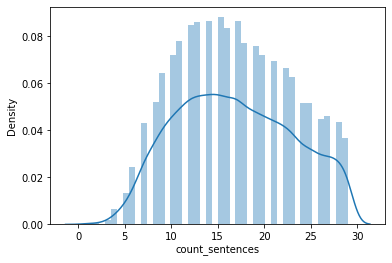

In [13]:
# story length distribution plot in the training dataset
train = train.sort_values(['story_id','sent_id'])
d2_sent_count = train.groupby('story_id').size().reset_index(name='count_sentences')
sns.distplot(d2_sent_count['count_sentences'])
plt.show()

In [14]:
# descriptive statistics of story length in the training dataset
d2_sent_count['count_sentences'].describe()

count    30000.000000
mean        16.843500
std          6.234375
min          1.000000
25%         12.000000
50%         16.000000
75%         22.000000
max         29.000000
Name: count_sentences, dtype: float64

In [15]:
# we note the maximum story length from the training dataset as we will
# be using this statistic for preprocessing
max_len_story = d2_sent_count['count_sentences'].max()
max_len_story

29

In [16]:
# total number of unique sentences in the training dataset
sent_ls = set(train['sentence'].tolist())
len(sent_ls)

484438

In [17]:
# unique labels in the training dataset
# 0: sentence is not a summary candidate
# 1: sentence is a summary candidate
tags = list(set(train['label_sent'].values))
n_tags = len(tags)
n_tags

2

# **Dataset Preprocessing**

Represent the sentences with integer tokens, pad the sentences to the maximum sentence length, and represent the corresponding labels in 0s and 1s.

This is an important step, as it helps with choosing and setting some of the model configuration parameters, such as the maximum_story_length and maximum_sentence_length.
The choice regarding the maximum_story_length and maximum_sentence_length is determined based on the statistical distribution of those parameters and for the majority of the stories in the dataset.

In [18]:
# encoding the sentence labels and reversing them
tag2idx  = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['PAD'] = 0
idx2tag = {i: s for s, i in tag2idx.items()}
print(tag2idx)

{0: 1, 1: 2, 'PAD': 0}


In [19]:
def add_word_lengths(df):
    df['word_len'] = df['sentence'].progress_apply(lambda x: len(x.split()))
    df['word_lis'] = df['sentence'].progress_apply(lambda x: x.split())
    return df

In [20]:
train = add_word_lengths(train)
valid = add_word_lengths(valid)
test = add_word_lengths(test)

train.head()

100%|██████████| 168546/168546 [00:01<00:00, 143666.07it/s]
<ipython-input-19-c10b9c3d8801>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_len'] = df['sentence'].progress_apply(lambda x: len(x.split()))
100%|██████████| 168546/168546 [00:01<00:00, 106518.41it/s]
<ipython-input-19-c10b9c3d8801>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_lis'] = df['sentence'].progress_apply(lambda x: x.split())
100%|██████████| 168504/168504 [00:03<00:00, 44695.95it/s]


,story_id,sent_id,sentence,label_sent,word_len,word_lis
0,0,0,in business if one of our companies is failing...,0,37,"[in, business, if, one, of, our, companies, is..."
1,0,1,its this kind of logic that underpins a new re...,1,33,"[its, this, kind, of, logic, that, underpins, ..."
2,0,2,im a member of the commission and i am pleased...,1,89,"[im, a, member, of, the, commission, and, i, a..."
3,0,3,this latest report taking control pathways to ...,1,49,"[this, latest, report, taking, control, pathwa..."
4,0,4,the reality is that the most effective way to ...,1,55,"[the, reality, is, that, the, most, effective,..."


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


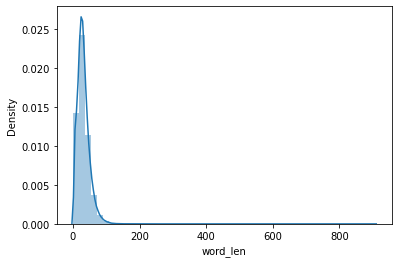

In [21]:
# sentence length distribution per story from the training dataset
sns.distplot(train['word_len'])
plt.show()

In [22]:
# descriptive statistics of sentence length distribution per story 
# from the training dataset
train['word_len'].describe()

count    505305.000000
mean         31.523084
std          18.216125
min           1.000000
25%          19.000000
50%          29.000000
75%          41.000000
max         907.000000
Name: word_len, dtype: float64

In [23]:
# total number of unique words in our training corpus
word_ls = set(list(chain(*train['word_lis'].tolist())))
n_words = len(word_ls)
print(n_words)

166254


In [24]:
# mapping the words to integers (tokenization) because machines don't
# understand raw text
word2idx = {c: i+2 for i,c in enumerate(word_ls)}
word2idx['UNK'] = 1
word2idx['PAD'] = 0

# reversing this dictionary as this would be needed for post-processing
idx2word = {i: s for s, i in word2idx.items()}

In [25]:
def append_sent_labels(df):
    df['sent_lab'] = df[['sentence','label_sent']].apply(tuple, axis=1)
    return df

In [26]:
train = append_sent_labels(train)
valid = append_sent_labels(valid)
test = append_sent_labels(test)

train.head()

<ipython-input-25-bd523398f5f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_lab'] = df[['sentence','label_sent']].apply(tuple, axis=1)


,story_id,sent_id,sentence,label_sent,word_len,word_lis,sent_lab
0,0,0,in business if one of our companies is failing...,0,37,"[in, business, if, one, of, our, companies, is...",(in business if one of our companies is failin...
1,0,1,its this kind of logic that underpins a new re...,1,33,"[its, this, kind, of, logic, that, underpins, ...",(its this kind of logic that underpins a new r...
2,0,2,im a member of the commission and i am pleased...,1,89,"[im, a, member, of, the, commission, and, i, a...",(im a member of the commission and i am please...
3,0,3,this latest report taking control pathways to ...,1,49,"[this, latest, report, taking, control, pathwa...",(this latest report taking control pathways to...
4,0,4,the reality is that the most effective way to ...,1,55,"[the, reality, is, that, the, most, effective,...",(the reality is that the most effective way to...


In [27]:
# sanity check the unique story ids in each of the splits
train['story_id'].nunique(), valid['story_id'].nunique(), test['story_id'].nunique()

(30000, 10000, 10000)

In [28]:
# we can play with this number but for now we will settle with 40
MAX_LEN_WORD = 40

def represent_stories(df):
    # filter out the labels from the data subset
    story_ids = df['story_id'].unique()
    stories_labels = []
    for s_id in tqdm(story_ids):
        temp_story = []
        # get all the sentences with respect to the givcen story id
        temp_story = list(df[df['story_id'] == s_id]['sent_lab'])
        stories_labels.append(temp_story)
    
    # initialize an all-zeros array in the shape of 
    # (nb_stories, max_story_length, max_sentence_lenght)
    X_word = np.zeros((len(stories_labels), max_len_story, MAX_LEN_WORD))
    
    for idx, story in tqdm(enumerate(stories_labels)):
        story_seq = []
        
        # to give an upper bound on the maximum length of the word sequence for sentence
        for i in range(max_len_story):
            sent_seq = []
            
            # to give an upper bound on the maximum length of words to consider
            for j in range(MAX_LEN_WORD):
                try:
                    split_sent = story[i][0].split()
                    sent_seq.append(word2idx.get(split_sent[j]))
                except:  
                    # exception will be there when there will not be any sentence for the length 
                    # and will be padded 0
                    sent_seq.append(word2idx.get('PAD'))
            story_seq.append(sent_seq)
        
        X_word[idx] = np.array(story_seq)

    return (X_word, stories_labels)

In [29]:
# preprocess the training corpus
X_train, stories_labels_train = represent_stories(train)
X_train.shape

100%|██████████| 30000/30000 [00:23<00:00, 1256.49it/s]
30000it [00:45, 656.88it/s]


(30000, 29, 40)

In [30]:
# preprocess the validation set
X_valid, stories_labels_valid = represent_stories(valid)
X_valid.shape

100%|██████████| 10000/10000 [00:04<00:00, 2024.43it/s]
10000it [00:14, 709.82it/s]


(10000, 29, 40)

In [31]:
def prepare_labels(story_labels):
    y = [[tag2idx[w[1]] for w in s] for s in story_labels]
    y = pad_sequences(maxlen=max_len_story, 
                  sequences=y, 
                  value=tag2idx["PAD"], 
                  padding='post', 
                  truncating='post')
    y = y.reshape(-1, max_len_story, 1)
    
    return y

In [32]:
# preprocess the train and validation labels
train_labels = prepare_labels(stories_labels_train)
valid_labels = prepare_labels(stories_labels_valid)

train_labels.shape, valid_labels.shape

((30000, 29, 1), (10000, 29, 1))

# **Model building**

Building a neural model using the TimeDistributed, CNN, LSTM, Embedding, Bidirectional, and Dense layers from Keras.Initializing the Embedding layer to have the pre-trained "GloVe: Global Vectors for Word Representation" embeddings.



*   The architecture that works extremely well for my case is the CNN-LSTM-based architecture. This is because the CNNs can efficiently encode the neighborhood information and the LSTMs capture the sequential information of the text document.

*   In this case, the text embedding matrix has been initialized with pre-trained GloVe embeddings. The main reason is that the GloVe embeddings already capture the semantic relationship between the words of a large text corpus, so it’s helpful for our model’s embedding layer to get initialized with the GloVe vectors. Initializing the text embedding matrix with the pre-trained GloVe embeddings gives the deep neural model a good initialization, which helps the model converge faster and more efficiently.

*   Moreover, in this case, the TimeDistributed layer has been used instead of the vanilla linear/non-linear layer. We use it because the problem is a sequence tagging problem and, therefore, the output with respect to each sequence/time point needs to be monitored. This problem falls into the class of entity extraction or sequence tagging problems, where each sequence needs to be tagged into one of the categories that need TimeDistributed implementation.
*   Furthermore, this approach is well tested.Starting with a relatively standardized approach is likely going to get you better results faster.





## **Using GloVe 100d embeddings**

Create an embedding matrix in which integer encodings of the words from our vocabulary get mapped to their corresponding vector representations from the GloVe embeddings.

In [33]:
# Reference: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
def get_embedding_matrix(word_index, embedding_path, embedding_dim):
    embedding_matrix_all = {}
    with open(embedding_path) as f:
        for line in f:  # every line contains word followed by the vector value
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix_all[word] = coefs

    # prepare embedding matrix with just the words in our word_index dictionary
    num_words = len(word_index) 
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embedding_matrix_all.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
  
    return embedding_matrix



    

## **Build your model in tf.keras**

The “weights” argument of the embedding layer is initialized to the embedding matrix created earlier.
The embedding layer is be trainable as well.
The activation for the last dense layer is “softmax.”

In [34]:
# construct the model
EMBEDDING_PATH = '/content/drive/MyDrive/project/glove.6B.100d.txt'
EMBEDDING_DIM = 100

def get_baseline_model1():
    #max_len_story=29 
    #max_len_word=40
    #n_words=166254
    word_in = Input(shape=(max_len_story, MAX_LEN_WORD,))

    emb_word = TimeDistributed(
        Embedding(input_dim=(n_words + 2), 
            output_dim=EMBEDDING_DIM,
            input_length=MAX_LEN_WORD, 
            weights=[get_embedding_matrix(word2idx, 
                EMBEDDING_PATH, EMBEDDING_DIM)], 
            trainable=True
        )	
    )(word_in)


    conv_layer = TimeDistributed(Convolution1D(128, 3, activation='relu'))(emb_word)
    conv_layer = TimeDistributed(GlobalAveragePooling1D())(conv_layer)
    main_lstm = Bidirectional(LSTM(units=32, return_sequences=True))(conv_layer)
    out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)
    
    model = Model([word_in], out)
    

    return model

In [35]:
# model summary
model1 = get_baseline_model1()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29, 40)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 29, 40, 100)      16625600  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 29, 38, 128)      38528     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 29, 128)          0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 29, 64)           41216     
 l)                                                          

## **Plot the model architecture**

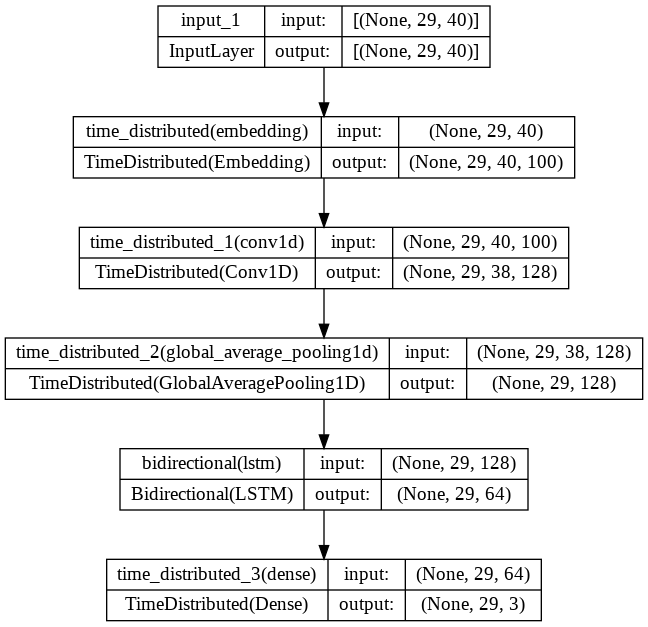

In [36]:
tf.keras.utils.plot_model(model1, 'model1.png', show_shapes=True)

## **Model training**

Training the CNN-LSTM models and specifying the values of all the parameters and hyperparameters of the model, including epochs, batch_size, optimizers, and metrics to be monitored.



The use of wandb not only helps with saving the best snapshot of the model but also provides a set of useful visualizations of the model performance in terms of its accuracy metrics, which in turn helps in making better decisions.

In [37]:
!pip install wandb -qq
# import wandb and authenticate it
import wandb
from wandb.keras import WandbCallback

wandb.login()

     |████████████████████████████████| 1.9 MB 29.7 MB/s 
     |████████████████████████████████| 182 kB 68.1 MB/s 
     |████████████████████████████████| 174 kB 63.1 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 173 kB 73.6 MB/s 
     |████████████████████████████████| 168 kB 75.7 MB/s 
     |████████████████████████████████| 168 kB 77.3 MB/s 
     |████████████████████████████████| 166 kB 75.0 MB/s 
     |████████████████████████████████| 166 kB 75.1 MB/s 
     |████████████████████████████████| 162 kB 77.9 MB/s 
     |████████████████████████████████| 162 kB 76.8 MB/s 
     |████████████████████████████████| 158 kB 75.6 MB/s 
     |████████████████████████████████| 157 kB 77.8 MB/s 
     |████████████████████████████████| 157 kB 73.3 MB/s 
     |████████████████████████████████| 157 kB 68.7 MB/s 
     |████████████████████████████████| 157 kB 76.1 MB/s 
     |████████████████████████████████| 157 kB 77.5 MB/s 
     |██████████

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [38]:
# set up an early stopping callback to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [39]:
# initialize wandb
wandb.init(project="text_summarizer", entity="chimi-pt")

wandb: Currently logged in as: chimi-pt. Use `wandb login --relogin` to force relogin


In [40]:
# reinitialize, compile, and train the model
model1 = get_baseline_model1()
model1.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model1.fit([X_train],
     train_labels, 
     validation_data=([X_valid], valid_labels),
     batch_size=64, 
     epochs=10,
     callbacks=[es, WandbCallback()],
     verbose=1)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8379

wandb: Adding directory to artifact (/content/wandb/run-20221220_161304-13m65znv/files/model-best)... Done. 1.2s


469/469 [==============================] - 52s 68ms/step - loss: 0.3519 - accuracy: 0.8379 - val_loss: 0.3046 - val_accuracy: 0.8562
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8599

wandb: Adding directory to artifact (/content/wandb/run-20221220_161304-13m65znv/files/model-best)... Done. 1.2s


469/469 [==============================] - 30s 64ms/step - loss: 0.2963 - accuracy: 0.8599 - val_loss: 0.2989 - val_accuracy: 0.8593
Epoch 3/10
469/469 [==============================] - 14s 30ms/step - loss: 0.2804 - accuracy: 0.8685 - val_loss: 0.3015 - val_accuracy: 0.8554
Epoch 4/10
469/469 [==============================] - 14s 29ms/step - loss: 0.2619 - accuracy: 0.8796 - val_loss: 0.3129 - val_accuracy: 0.8508


In [41]:
# serialize model for later use
model1.save('baseline_summarizer.h5')

In [42]:
import pickle
# set the output object name
filename = 'output.pkl'
# serialize (save) the object, in this case "model"
pickle.dump(model1, open(filename, 'wb'))

In [43]:
# saving the model
pickle.dump(model1, open('model.pkl', 'wb'))

# Running Sample Predictions and Evaluating the Baseline Model

## Preparing a Single Test Data Point

Preprocessing of the test data point and ensuring that all the relevant preprocessing done to the training data is replicated here. Otherwise, the model might not understand the input format, which would result in an error.

In [44]:
def represent_single_story(df, story_id):
	stories_labels = []
	temp_story = []
	
	# get all the sentences with respect to the givcen story id
	temp_story = list(df[df['story_id'] == story_id]['sent_lab'])
	stories_labels.append(temp_story)
	
	# initialize an all-zeros array in the shape of 
	# (nb_stories, max_story_length, max_sentence_lenght)
	X_word = np.zeros((len(stories_labels), max_len_story, MAX_LEN_WORD))
	
	for idx, story in tqdm(enumerate(stories_labels)):
		story_seq = []
		
		# to give an upper bound on the maximum length of the word sequence for sentence
		for i in range(max_len_story):
			sent_seq = []
			
			# to give an upper bound on the maximum length of words to consider
			for j in range(MAX_LEN_WORD):
				try:
					split_sent = story[i][0].split()
					sent_seq.append(word2idx.get(split_sent[j]))
				except:  
					# exception will be there when there will not be any sentence for the length 
					# and will be padded 0
					sent_seq.append(word2idx.get('PAD'))
			story_seq.append(sent_seq)
		
		X_word[idx] = np.array(story_seq)

	return (X_word, stories_labels)

In [101]:
# get a random story id from the test set
random_test_story_id = np.random.choice(np.unique(test['story_id'].tolist()), 1)[0]
random_test_story_id

52899

In [102]:
# preprocess the story 
X_word_test_single_story, story_labels_single = represent_single_story(test, random_test_story_id)
X_word_test_single_story.shape

1it [00:00, 246.22it/s]


(1, 29, 40)

In [103]:
# preprocess the labels associated with the story
y_test_single = prepare_labels(story_labels_single)
y_test_single.shape

(1, 29, 1)

In [104]:
# run the model to predict on the preprocessed story and take an argmax
# along the last dimension
summary_predicted = model1.predict(X_word_test_single_story).argmax(axis=-1)
summary_predicted.shape

1/1 [==============================] - 0s 22ms/step


(1, 29)

In [105]:
# let's manually see the predictions and compare them with the ground truth labels
print(summary_predicted)
print(y_test_single.squeeze(axis=-1))

[[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
[[2 2 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]


Tag of 2 denotes that the corresponding sentence within a story is a summary candidate. 

In [106]:
# get the index from prediction array where the value is 2
# and use it to query the preprocessed test story
idx = np.where(summary_predicted==2)
summary_predicted = X_word_test_single_story[idx]

In [107]:
decoded_predictions = []

# decode the predictions
for i in range(len(summary_predicted)):
    # get the sentence
    sentence_encoded = summary_predicted[i]
    
    # initialize an empty list to populate the decoded words with
    sentence_deocded = [idx2word.get(idx) for idx in sentence_encoded if idx!=0 if idx2word.get(idx) is not None]
    
    # prepare the sentence
    sentence_deocded = ' '.join(sentence_deocded)
    
    decoded_predictions.append(sentence_deocded)

## **Predictions**

In [108]:
# preview
print(f'Predicted summaries of story id {random_test_story_id}')
decoded_predictions

Predicted summaries of story id 52899


['the biggest surprise on a busy night of international football on wednesday came in duesseldorf where euro finalists germany were beaten by norway for the first time in years']

In [109]:
# let's now see the original summary candidates
print(f'Original summaries of story id {random_test_story_id}')
test.query('story_id == @random_test_story_id & label_sent==1')['sentence'].tolist()

Original summaries of story id 52899


['the biggest surprise on a busy night of international football on wednesday came in duesseldorf where euro finalists germany were beaten by norway for the first time in years',
 'norway players celebrate christian grindheims goal in their shock victory over germany',
 'in marseille lionel messi scored a brilliant solo goal to give argentina a win over france and give diego maradona a second straight win as national coach',
 'elsewhere arsenal striker eduardo da silva returned to action for the first time since breaking his leg months ago helping croatia to a victory over romania in bucharest',
 'drogba who has been out of favor for his club side this season tapped in a cross from the right in the second minute of injury time in his first match for his country in over a year']

# Evaluating The Model

the model performance on unseen test data is crucial. In this case, variants of F1 metrics have been considered as the relevant metric for the generalizability check, since the F1 metric provides a sense of both the sensitivity and specificity of the model.

The F1 score is a measure of a test’s accuracy and is defined as the weighted harmonic mean of precision and recall. The ideal or best value of an F1 score is 1 and the worst value is 0. However, when there is a class imbalance, the F1 score is a better metric than accuracy.

there is an imbalance amongst the classes, namely important and unimportant, since there will only be a few sentences in a passage that are important to be in the summary. Hence, in our case, the F1 score has been selected as the relevant metric.

In [110]:
# first preprocess the entire test set
X_test, stories_labels_test = represent_stories(test)
X_test.shape

100%|██████████| 10000/10000 [00:05<00:00, 1905.95it/s]
10000it [00:15, 655.27it/s]


(10000, 29, 40)

In [111]:
test_labels = prepare_labels(stories_labels_test)
test_labels = test_labels.squeeze(-1) # to make it compatible for the evaluation metrics
test_labels.shape

(10000, 29)

Make predictions regarding the preprocessed data points using the model
Apply an argmax operation on the predictions along the last dimension. You should get an array with a dimension of (10000, 29).

In [57]:
# retrieve the predictions from all the test data points and take argmax along the last dimension
test_predictions = model1.predict(X_test).argmax(axis=-1)
test_predictions.shape

313/313 [==============================] - 2s 4ms/step


(10000, 29)

In [58]:
# evaluation metrics
from sklearn.metrics import precision_score, recall_score , f1_score

Calculate three F1 scores (macro, micro, and weighted) between the preprocessed ground truth labels and the predictions.

In [59]:
f1_macro = []
f1_micro = []
f1_weight = []

for i in tqdm(range(0, len(test_labels))) :
    
    metric_macro = f1_score(test_labels[i], test_predictions[i], average='macro')
    metric_micro = f1_score(test_labels[i], test_predictions[i], average='micro')
    metric_weight = f1_score(test_labels[i], test_predictions[i], average='weighted')
    
    f1_macro.append(metric_macro)
    f1_micro.append(metric_micro)
    f1_weight.append(metric_weight)

100%|██████████| 10000/10000 [00:28<00:00, 356.90it/s]


In [60]:
# create a dataframe from the numbers
df_metric = pd.DataFrame()
df_metric['f1_macro'] =  f1_macro
df_metric['f1_micro'] =  f1_micro
df_metric['f1_weight'] = f1_weight

df_metric.head()

,f1_macro,f1_micro,f1_weight
0,0.683333,0.793103,0.774138
1,0.832753,0.896552,0.878169
2,0.750000,0.862069,0.821839
3,0.817143,0.896552,0.880591
4,0.632653,0.827586,0.750176


## Serialization of other important results

In [61]:
train.to_csv('train.csv', index=False)
valid.to_csv('valid.csv', index=False)
test.to_csv('test.csv', index=False)

In [62]:
import pickle

pickle.dump(word2idx, open('word_dictionary.pkl', 'wb'))
pickle.dump(idx2word, open('inverse_word_dictionary.pkl', 'wb'))

# Plugging an Attention Mechanism into Our CNN-LSTM Model

## Training a CNN-LSTM Model with an Attention Mechanism

Attention mechanism in the CNN-LSTM architecture helps the model attend to specific portions of the input dynamically. In this specific problem, I have used attention at the word level for the sentences in the story.

Attention mechanism adds very few parameters to the network, but, by adding attention to the network, it allows the network to work with fewer parameters

Setup again

In [63]:
# prepare TensorFlow dataset for optimized performance (optional)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
train_ds = (
    train_ds
    .batch(64)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, valid_labels))
validation_ds = (
    validation_ds
    .batch(64)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## New Model

In [64]:
# construct the model
EMBEDDING_PATH = '/content/drive/MyDrive/project/glove.6B.100d.txt'
EMBEDDING_DIM = 100

def get_baseline_model2():
    word_in = Input(shape=(max_len_story, MAX_LEN_WORD,))

    emb_word = TimeDistributed(
        Embedding(input_dim=(n_words + 2), 
            output_dim=EMBEDDING_DIM,
            input_length=MAX_LEN_WORD,
            weights=[get_embedding_matrix(word2idx, 
                EMBEDDING_PATH, EMBEDDING_DIM)], 
            trainable=True
        )	
    )(word_in)

    emb_word2 = TimeDistributed(Convolution1D(32, 2, activation='relu',padding= 'same'))(emb_word)
    
    activations_weights = TimeDistributed(Dense(1, activation='tanh'))(emb_word2)
    activations_weights = TimeDistributed(Flatten())(activations_weights)
    activations_weights = TimeDistributed(Activation('softmax'))(activations_weights)
    activations_weights = TimeDistributed(RepeatVector(32))(activations_weights)
    activations_weights = TimeDistributed(Permute([2, 1]))(activations_weights)
    activations_weighted = multiply([emb_word2,activations_weights])
    
    emb_sent = TimeDistributed(Lambda(lambda x: K.sum(x, axis=-2)))(activations_weighted)
    
    main_lstm = Bidirectional(LSTM(units=16, return_sequences=True))(emb_sent)
    out = TimeDistributed(Dense(n_tags + 1, activation='softmax'))(main_lstm)

    model = Model([word_in], out)

    return model

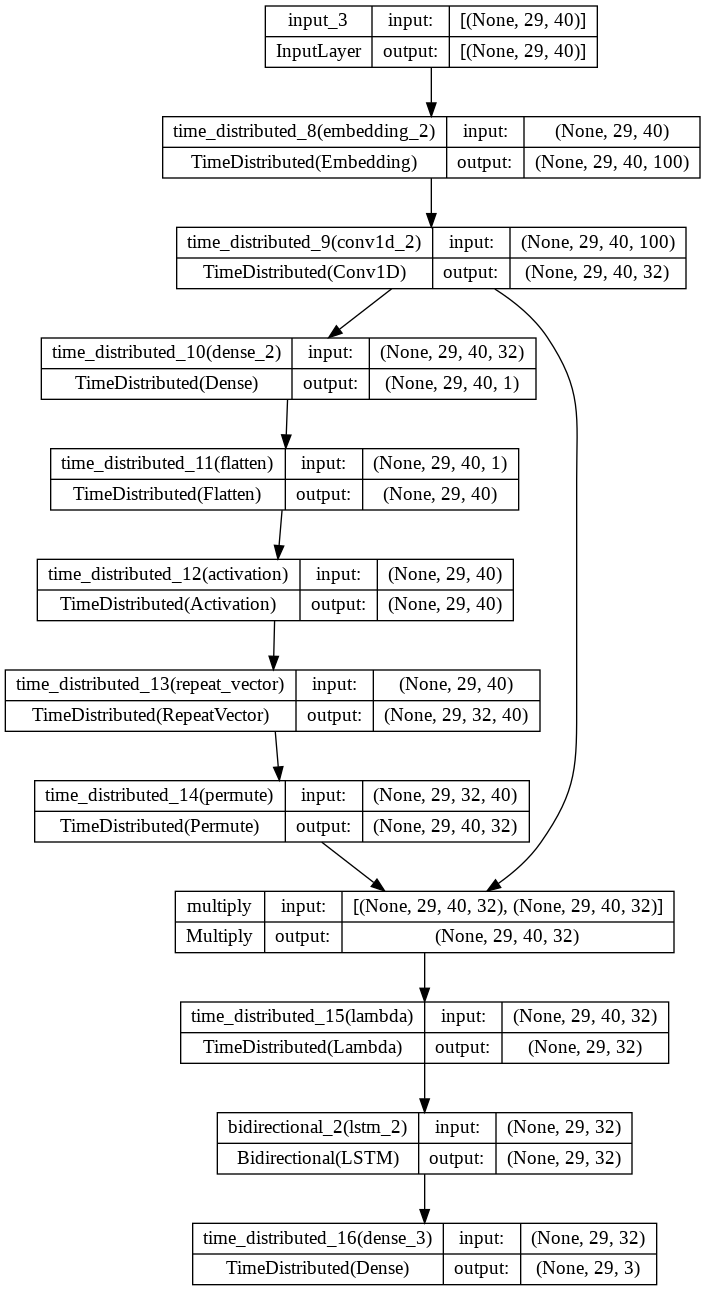

In [65]:
# plot the model architecture
model2 = get_baseline_model2()
tf.keras.utils.plot_model(model2, 'model2.png', show_shapes=True)

## Train the model

Train with a learning rate schedule.

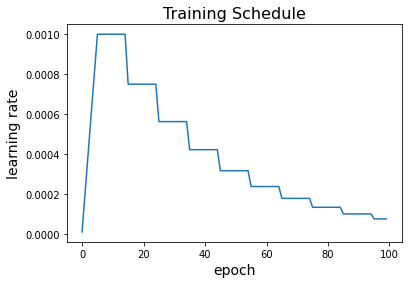

In [66]:
# CUSTOM LEARNING SCHEUDLE
# Reference: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

In [67]:
wandb.init(project="text_summarizer", entity="chimi-pt")

optimizer = tf.keras.optimizers.Adam(lr=0.00001)

# reinitialize, compile, and train the model
model2 = get_baseline_model2()
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.fit(train_ds,
     validation_data=validation_ds,
     epochs=50,
     callbacks=[es, lr2, WandbCallback()],
     verbose=1)

accuracy,▁▅▆█
epoch,▁▃▆█
loss,█▄▂▁
val_accuracy,▅█▅▁
val_loss,▄▁▂█
accuracy,0.87956
best_epoch,1
best_val_loss,0.29887
epoch,3
loss,0.26191
val_accuracy,0.85076


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
469/469 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.4403

wandb: Adding directory to artifact (/content/wandb/run-20221220_161739-3oms0ej5/files/model-best)... Done. 1.2s


469/469 [==============================] - 34s 65ms/step - loss: 1.0697 - accuracy: 0.4403 - val_loss: 1.0484 - val_accuracy: 0.4801 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.000208.
Epoch 2/50
468/469 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8138

wandb: Adding directory to artifact (/content/wandb/run-20221220_161739-3oms0ej5/files/model-best)... Done. 1.1s


469/469 [==============================] - 29s 63ms/step - loss: 0.4338 - accuracy: 0.8139 - val_loss: 0.3253 - val_accuracy: 0.8493 - lr: 2.0800e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000406.
Epoch 3/50
467/469 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8515

wandb: Adding directory to artifact (/content/wandb/run-20221220_161739-3oms0ej5/files/model-best)... Done. 1.2s


469/469 [==============================] - 27s 58ms/step - loss: 0.3171 - accuracy: 0.8515 - val_loss: 0.3112 - val_accuracy: 0.8536 - lr: 4.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0006039999999999999.
Epoch 4/50
469/469 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8575

wandb: Adding directory to artifact (/content/wandb/run-20221220_161739-3oms0ej5/files/model-best)... Done. 1.1s


469/469 [==============================] - 29s 62ms/step - loss: 0.3023 - accuracy: 0.8575 - val_loss: 0.2990 - val_accuracy: 0.8583 - lr: 6.0400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000802.
Epoch 5/50
469/469 [==============================] - 12s 25ms/step - loss: 0.2891 - accuracy: 0.8640 - val_loss: 0.2998 - val_accuracy: 0.8575 - lr: 8.0200e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/50
469/469 [==============================] - 12s 25ms/step - loss: 0.2757 - accuracy: 0.8717 - val_loss: 0.3074 - val_accuracy: 0.8535 - lr: 0.0010


## Running Sample Predictions and Evaluating Our Attention-Based Model

Run inference on test data points with the attention-based model and evaluate the model using the F1 score.

Run sample predictions with the attention-based model

In [112]:
def represent_single_story(df, story_id):
	stories_labels = []
	temp_story = []
	
	# get all the sentences with respect to the givcen story id
	temp_story = list(df[df['story_id'] == story_id]['sent_lab'])
	stories_labels.append(temp_story)
	
	# initialize an all-zeros array in the shape of 
	# (nb_stories, max_story_length, max_sentence_lenght)
	X_word = np.zeros((len(stories_labels), max_len_story, MAX_LEN_WORD))
	
	for idx, story in tqdm(enumerate(stories_labels)):
		story_seq = []
		
		# to give an upper bound on the maximum length of the word sequence for sentence
		for i in range(max_len_story):
			sent_seq = []
			
			# to give an upper bound on the maximum length of words to consider
			for j in range(MAX_LEN_WORD):
				try:
					split_sent = story[i][0].split()
					sent_seq.append(word2idx.get(split_sent[j]))
				except:  
					# exception will be there when there will not be any sentence for the length 
					# and will be padded 0
					sent_seq.append(word2idx.get('PAD'))
			story_seq.append(sent_seq)
		
		X_word[idx] = np.array(story_seq)

	return (X_word, stories_labels)

In [113]:
# get a random story id from the test set
random_test_story_id = np.random.choice(np.unique(test['story_id'].tolist()), 1)[0]
random_test_story_id

57577

In [114]:
# preprocess the story 
X_word_test_single_story, story_labels_single = represent_single_story(test, random_test_story_id)
X_word_test_single_story.shape

1it [00:00, 230.74it/s]


(1, 29, 40)

In [115]:
# preprocess the labels associated with the story
y_test_single = prepare_labels(story_labels_single)
y_test_single.shape

(1, 29, 1)

In [116]:
# run the model to predict on the preprocessed story and take an argmax
# along the last dimension
summary_predicted = model2.predict(X_word_test_single_story).argmax(axis=-1)
summary_predicted.shape

1/1 [==============================] - 0s 21ms/step


(1, 29)

In [117]:
# let's manually see the predictions and compare them with the ground truth labels
print(summary_predicted)
print(y_test_single.squeeze(axis=-1))

[[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]]
[[2 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 0 0]]


In [118]:
# get the index from prediction array where the value is 2
# and use it to query the preprocessed test story
idx = np.where(summary_predicted==2)
summary_predicted = X_word_test_single_story[idx]

In [119]:
decoded_predictions = []

# decode the predictions
for i in range(len(summary_predicted)):
    # get the sentence
    sentence_encoded = summary_predicted[i]
    
    # initialize an empty list to populate the decoded words with
    sentence_decoded = [idx2word.get(idx) for idx in sentence_encoded if idx!=0 if idx2word.get(idx)!=None]
    
    # prepare the sentence
    sentence_decoded = ' '.join(sentence_decoded)
    
    decoded_predictions.append(sentence_decoded)

In [120]:
# preview
print(f'Predicted summaries of story id {random_test_story_id}')
decoded_predictions

Predicted summaries of story id 57577


['lance armstrong seventime winner of the tour de france on thursday announced he would no longer contest charges that he doped his way to victory the legendary cyclist still maintains hes innocent']

In [121]:
# let's now see the original summary candidates
print(f'Original summaries of story id {random_test_story_id}')
test.query('story_id == @random_test_story_id & label_sent==1')['sentence'].tolist()

Original summaries of story id 57577


['lance armstrong seventime winner of the tour de france on thursday announced he would no longer contest charges that he doped his way to victory the legendary cyclist still maintains hes innocent',
 'armstrong vehemently maintains that he has never doped and that he has never failed a drug test he accused the usada of pursuing an unconstitutional witch hunt against him and he maintained the usada does not have the right to prosecute him on monday a us federal court ruled against the cyclist',
 'what about armstrongs record seven tour de france titles',
 'its unclear if usada has the power to strip armstrong of his tour de france titles or if that jurisdiction lies with the uci',
 'on his site armstrong wrote usada cannot assert control of a professional international sport and attempt to strip my seven tour de france titles i know who won those seven tours my teammates know who won those seven tours and everyone i competed against knows who won those seven tours']

In [78]:
# first preprocess the entire test set
X_test, stories_labels_test = represent_stories(test)
X_test.shape

100%|██████████| 10000/10000 [00:05<00:00, 1934.82it/s]
10000it [00:13, 715.01it/s]


(10000, 29, 40)

In [79]:
test_labels = prepare_labels(stories_labels_test)
test_labels = test_labels.squeeze(-1) # to make it compatible for the evaluation metrics
test_labels.shape

(10000, 29)

In [80]:
# retrieve the predictions from all the test data points and take argmax along the last dimension
test_predictions = model2.predict(X_test).argmax(axis=-1)
test_predictions.shape

313/313 [==============================] - 2s 4ms/step


(10000, 29)

## Evaluate the model

In [81]:
# evaluation metrics
from sklearn.metrics import f1_score

In [82]:
f1_macro = []
f1_micro = []
f1_weight = []

for i in tqdm(range(0, len(test_labels))) :
    
    metric_macro = f1_score(test_labels[i], test_predictions[i],average = 'macro')
    metric_micro = f1_score(test_labels[i], test_predictions[i],average = 'micro')
    metric_weight = f1_score(test_labels[i], test_predictions[i],average = 'weighted')
    
    f1_macro.append(metric_macro)
    f1_micro.append(metric_micro)
    f1_weight.append(metric_weight)

100%|██████████| 10000/10000 [00:19<00:00, 507.60it/s]


In [83]:
# create a dataframe from the numbers
df_metric = pd.DataFrame()
df_metric['f1_macro'] =  f1_macro
df_metric['f1_micro'] =  f1_micro
df_metric['f1_weight'] = f1_weight

df_metric.head()

,f1_macro,f1_micro,f1_weight
0,0.683333,0.793103,0.774138
1,0.832753,0.896552,0.878169
2,0.750000,0.862069,0.821839
3,0.777778,0.862069,0.850575
4,0.750000,0.862069,0.821839


## Attention maps

We are interested in the intermediate "softmax" layer that produces a tensor of shape `[None, max_story_length, max_sentence_length]`. Our aim is to get the attention weights of each of the words present in a summary (predicted by the model) sentence. 

In [84]:
model_with_attention = Model(model2.input, model2.layers[-7].output)
model_with_attention.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 29, 40)]          0         
                                                                 
 time_distributed_17 (TimeDi  (None, 29, 40, 100)      16625600  
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 29, 40, 32)       6432      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 29, 40, 1)        33        
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 29, 40)           0         
 stributed)                                                

In [85]:
# run the model to predict on a single preprocessed story and take an argmax
# along the last dimension
summary_predicted = model2.predict(X_word_test_single_story).argmax(axis=-1)
summary_predicted.shape

1/1 [==============================] - 0s 27ms/step


(1, 29)

In [86]:
# get the attention weights
attention_weights = model_with_attention.predict(X_word_test_single_story)
attention_weights.shape

1/1 [==============================] - 0s 96ms/step


(1, 29, 40)

In [87]:
# get the index from prediction array where the value is 2
# and use it to query the preprocessed test story
idx = np.where(summary_predicted==2)
summary_candidates_from_preds = X_word_test_single_story[idx]
summary_candidates_from_preds.shape

(7, 40)

In [88]:
# filtering the attention weights for summary candidates only
idx = np.where(summary_predicted==2)
summary_attention_weights = attention_weights[idx]
summary_attention_weights.shape

(7, 40)

In [89]:
single_pred_summary_idx = np.random.choice(len(summary_attention_weights), 1)

# selecting a single summary candidate
single_summary_candidate = summary_candidates_from_preds[single_pred_summary_idx]

# selecting a summary candidate randomly
single_candidate_weights = summary_attention_weights[single_pred_summary_idx]

print(single_summary_candidate.shape, single_candidate_weights.shape)

(1, 40) (1, 40)


In [90]:
single_summary_candidate

array([[ 53730., 164528., 116247.,  64092.,  97237.,  66907.,  51753.,
         81592., 118653., 152798.,  16699.,  44492.,  86278.,  49912.,
        126577.,   3041.,  52760.,  28020., 162028., 142135.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]])

In [91]:
sentence_decoded = [idx2word.get(idx) for idx in single_summary_candidate[0]]
' '.join(sentence_decoded)

'we are relying a little on this countrys tradition of producing worldclass drivers who potentially drive people through the gate PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

## Visualizing the Attention Weights

In [92]:
# create a temporary dataframe
df = pd.DataFrame()
df['words'] = (sentence_decoded)
df['attention_weights'] = single_candidate_weights.squeeze()

# filter out the top weights
df_sub = df.sort_values(by='attention_weights',ascending=False).head(10)
df_sub.head()

,words,attention_weights
0,we,0.045414
17,through,0.045414
16,people,0.045414
4,little,0.045414
5,on,0.045414


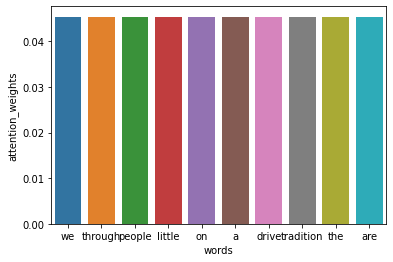

In [93]:
sns.barplot(x="words", y="attention_weights", data=df_sub)
plt.show()

# **Deploying the Model**

## Using flask

In [94]:
!pip install flask_ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 30.9 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=d5e42d89ff1b2158e70a909c42c44e9d48592319564308807645b68db2b625b6
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [96]:
 !ngrok authtoken 2J37EZbaf6Eks86WMbOOBAUSDaX_6xWv5DGAVQiANnVeHPWKn

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [97]:
import zipfile
from zipfile import ZipFile

file_name = '/content/drive/MyDrive/project/static.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Extracted Successfully')

Extracted Successfully


In [122]:
import flask
from flask import Flask, render_template, request
import pickle
import numpy as np
from flask_ngrok import run_with_ngrok
import warnings
warnings.filterwarnings('ignore')

app = Flask(__name__)
run_with_ngrok(app)

#model = pickle.load(open('model.pkl', 'rb'))

@app.route('/', methods=['GET'])
def home():
  return render_template('index.php')

@app.route('/uploadArticle')
def uploadArticle():
  return render_template('uploadArticle.php')


@app.route("/summarize", methods=['POST','GET'])
def getSummary():
    body=request.form['article']
    numbero=request.form.get('number',type=int)
    result = model3(body, num_sentences=numbero)
    return render_template('result.php',result=result)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://71ae-34-124-216-115.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:32] "GET /static/css/bootstrap.min.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:32] "GET /static/includes/scripts.php HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:32] "GET /static/images/mediagroup.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:32] "GET /static/images/MailBoy.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:32] "GET /static/images/Facebook.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:32] "GET /static/images/Twitter.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:33] "GET /static/images/GitHub.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:34] "GET /static/images/header-background.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2022 16:25:34] "GET /static/images/sc3.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0